## 5. Visualizing Solar Flux Density Using Animated Contour Plots
Now we have a function to approximate Solar Irradiance for any lattitude at any time of the year, so let's visualize it!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# print(plt.style.available)
plt.style.use('seaborn-pastel')  # bmh , seaborn-white are also nice

In [2]:
from math import pi, cos, sin, radians

# Constants
SOLAR_CONSTANT = 1361
AU = 149597870700
PERIHELION_DAY = 3
DAYS_IN_SIDEREAL_YEAR = 365.256
SEMI_MAJOR_AXIS = 1.496e11+10
ECCENTRICITY = 0.0167

DEC_FOURIER_COEFS = {"a_n": [0.006918, -0.399912, -0.006758, -0.002697],
                     "b_n": [0, 0.070257, 0.000907, 0.001480]}

# Earth Sun Distance
def calculate_days_from_perihelion(day_of_year):
    n = abs(day_of_year - PERIHELION_DAY)
    if n > (DAYS_IN_SIDEREAL_YEAR/2):
        return DAYS_IN_SIDEREAL_YEAR - n
    return n

def calculate_angle_from_perihelion(day_of_year):
    days_from_p = calculate_days_from_perihelion(day_of_year)
    return (2*pi*days_from_p)/DAYS_IN_SIDEREAL_YEAR

def earth_sun_distance_kepler(day_of_year):
    theta = calculate_angle_from_perihelion(day_of_year)
    return SEMI_MAJOR_AXIS*(1 - ECCENTRICITY**2)/(1 + ECCENTRICITY*cos(theta))

# Solar Zenith Angle
def time_of_year_radians(day_of_year):
    """Returns time of year in radians based on day of year input in range [0, 364]."""
    return (2*pi*day_of_year)/DAYS_IN_SIDEREAL_YEAR

def calculate_declination_angle(day_of_year):
    theta_d = time_of_year_radians(day_of_year)
    total = 0
    for n in range(4):
        total += (DEC_FOURIER_COEFS["a_n"][n] * cos(n*theta_d) +
                  DEC_FOURIER_COEFS["b_n"][n] * sin(n*theta_d))
    return total

def calculate_hour_angle(hour_of_day):
    if hour_of_day >= 12:
        hour = hour_of_day - 12
    elif hour_of_day < 12:
        hour = 12 - hour_of_day
    return radians(hour*15)

def calculate_cos_of_solar_zenith(day_of_year, hour_of_day, latitude):
    declination_angle = calculate_declination_angle(day_of_year)
    hour_angle = calculate_hour_angle(hour_of_day)
    lat_radians = (pi/180) * latitude
    return (sin(lat_radians)*sin(declination_angle) +
            cos(lat_radians)*cos(declination_angle)*cos(hour_angle))


# Flux Density
def calculate_flux_density(day_of_year, hour_of_day, latitude, atmospheric_loss=0):
    cos_of_solar_zenith = calculate_cos_of_solar_zenith(day_of_year, hour_of_day, latitude)
    
    # When the sun is below the horizon, cos_of_solar_zenith is negative.
    if cos_of_solar_zenith < 0:
        return 0
    
    distance_factor = (AU / earth_sun_distance_kepler(day_of_year))**2
    
    return SOLAR_CONSTANT*distance_factor*cos_of_solar_zenith

# Contour
Now we have a function to approximate Solar Irradiance for any lattitude at any time of the year, so let's visualize it!

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# print(plt.style.available)
plt.style.use('seaborn-pastel')  # bmh , seaborn-white are also nice

In [4]:
# Make Data
days_in_year = [day for day in range(365)]
latitudes = [lat for lat in range(-90,91)]
hours = [hour for hour in range(0, 25)]

days, lats = np.meshgrid(days_in_year, latitudes)

print("Days: " + str(len(days)) + " rows, " + str(len(days[0])) + " cols")
print(days[:5])

Days: 181 rows, 365 cols
[[  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]]


In [5]:
print("Lats: " + str(len(lats)) + " rows, " + str(len(lats[0])) + " cols")
print(lats[:5])

Lats: 181 rows, 365 cols
[[-90 -90 -90 ... -90 -90 -90]
 [-89 -89 -89 ... -89 -89 -89]
 [-88 -88 -88 ... -88 -88 -88]
 [-87 -87 -87 ... -87 -87 -87]
 [-86 -86 -86 ... -86 -86 -86]]


In [6]:
flux_function = np.vectorize(calculate_flux_density)

In [7]:
# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

def do_plot(days, hours, lats):
    '''One of days, hours, lats must be single value, other two meshed'''
    flux = flux_function(days, hours, lats)

    fig = plt.figure(figsize=(16,9))

    contours = plt.contour(days, lats, flux, 9, colors='black')
    clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
    im = plt.imshow(flux, extent=[0,364,-90,90], origin='lower', cmap='magma', alpha = 1)

    cbar = plt.colorbar(im, pad=0.02)

    # Plot Settings and Labels
    plt.clim(0, 1400)  # Keep colorbar range consistent
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel('Solar\nFlux\nDensity\n' + r'$\bf{\left(\frac{watts}{m^2}\right)}$',
                       rotation = 0, wrap=True, fontsize=20, weight='bold', labelpad=50)
    plt.xlabel('Day of Year', fontsize=24, weight='bold', labelpad=10)
    plt.ylabel('Latitude', fontsize=24, weight='bold')
    x_ticks=[d for d in range(0, 365, 30)] #.append(364)
    plt.xticks(x_ticks)
    plt.yticks([lat for lat in range(-90, 91, 30)])
    plt.tick_params(labelsize=20, pad=10)
    plt.title("Flux at: " + '{0:02.0f}:{1:02.0f}'.format(*divmod(float(hours) * 60, 60)),
              fontsize=30, pad=10, weight='bold')
    #clear_output(wait=True)
    return fig

In [8]:
#fig = do_plot(days, 12, lats)

### Homemade animation method

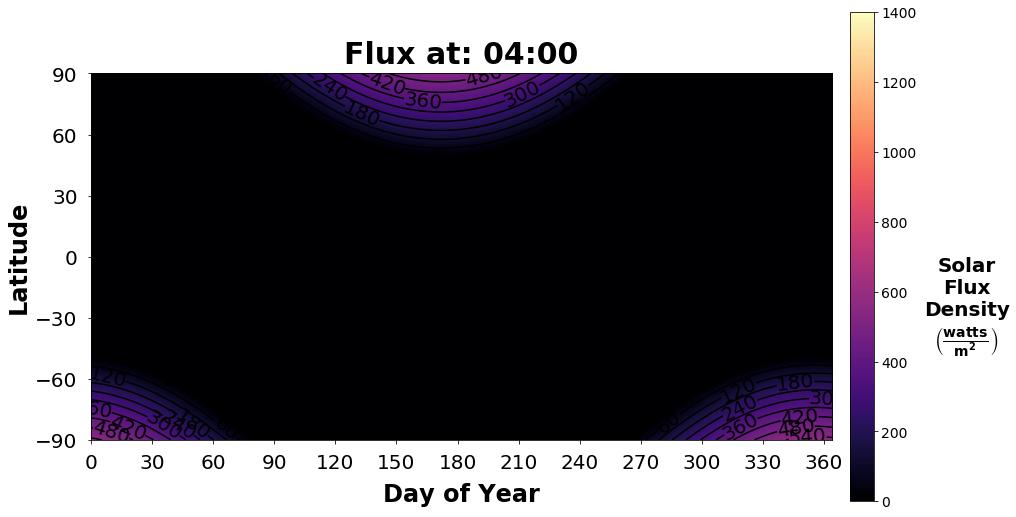

KeyboardInterrupt: 

<Figure size 1152x648 with 0 Axes>

In [9]:
from IPython.display import clear_output

for hour in range(0, 24):
    fig = do_plot(days, hour, lats)
    clear_output(wait=True)
    plt.show()

### Animate over hours of day

In [ ]:
# Make Data
min_day = 0
max_day = 364
min_lat = -90
max_lat = 90
min_hour = 0
max_hour = 23

days_in_year = [day for day in range(max_day+1)]
latitudes = [lat for lat in range(min_lat, max_lat+1)]

days, lats = np.meshgrid(days_in_year, latitudes)

# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

In [3]:
#%%capture
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
# print(plt.style.available)
plt.style.use('seaborn-white')  # bmh is also nice


In [ ]:
frames = 24  # Number of frames in animation
num_contours = 9
alpha = 0.95  # 0 to 1
start_hour = 0
min_flux = 0
max_flux = 1400
colorbar_label = 'Solar Flux\nDensity ' + r'$\bf{\left(\frac{watts}{m^2}\right)}$'

fig, ax = plt.subplots(figsize=(16, 9))

def draw_plot(hour):
    #day = day*((max_day-1)//frames)
    flux = flux_function(days, hour, lats)
    contours = plt.contour(days, lats, flux, num_contours, colors='black')
    clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
    im = plt.imshow(flux, extent=[min_day, max_day, min_lat, max_lat],
                    origin='lower', cmap='magma', alpha = alpha, aspect='auto')
    plt.clim(min_flux, max_flux)
    title = plt.title("Hour of Day: " + '{0:02.0f}:{1:02.0f}'.format(*divmod(float(hour) * 60, 60)),
              fontsize=30, pad=10, weight='bold')
    return (im, contours, clabel, title)

fig, ax = plt.subplots(figsize=(16, 9))  # Put %%capture above so we dont display this as static plot

def init():
    flux = flux_function(days, start_hour, lats)
    im = draw_plot(start_hour)[0]
    cbar = plt.colorbar(im, pad=0.02)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel(colorbar_label, rotation = 0, wrap=True, fontsize=20, weight='bold', labelpad=50)

def bs():
    ax.clear()
    ax.set_xlabel('Day of Year', fontsize=24, weight='bold', labelpad=10)
    ax.set_ylabel('Latitude', fontsize=24, weight='bold')
    plt.tick_params(labelsize=20, pad=10)
    plt.xticks([d for d in range(min_day, max_day+1, 30)])
    plt.yticks([lat for lat in range(min_lat, max_lat+1, 30)])

def animate(hour):
    bs()
    return draw_plot(hour)


interval = 0.5  # in seconds
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=interval*1e+3,
                               blit=False)

HTML(anim.to_jshtml())  # FOR SOME FUCKING REASON WE NEED THIS HERE!
                        # Then either do JSAnimation.IPython_display.display_animation(anim) OR
                        # %%capture at top of this cell, and HTML(anim.to_jshtml()) again in another cell.

from JSAnimation.IPython_display import display_animation
display_animation(anim)

## Animate Either

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from JSAnimation.IPython_display import display_animation
# print(plt.style.available)
plt.style.use('seaborn-white')  # bmh is also nice

In [4]:
min_lat = -90
max_lat = 90
min_hour = 0
max_hour = 23
min_day = 0
max_day = 364
resolution = 4

days_in_year = [day for day in range(max_day+1)]
hours = [hour/resolution for hour in range(resolution*(max_hour+1)-1)]
latitudes = [lat for lat in range(min_lat, max_lat + 1)]

# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

frames = 48  # Number of frames in animation
num_contours = 20
alpha = 0.95  # 0 to 1
start_day = 0
min_flux = 0
max_flux = 1400
colorbar_label = 'Solar Flux\nDensity ' + r'$\bf{\left(\frac{watts}{m^2}\right)}$'

In [5]:
def make_animation(days, num_contours, frames):
    if days:
        x_var, lats = np.meshgrid(hours, latitudes)
        min_t, max_t, min_x, max_x = min_day, max_day, min_hour, max_hour
        title_start = "Day of Year: "
        x_lab = "Hour of Day"
        x_ticks = [d for d in range(max_hour+1)]
    else:
        x_var, lats = np.meshgrid(days_in_year, latitudes)
        min_t, max_t, min_x, max_x = min_hour, max_hour, min_day, max_day
        title_start = "Hour of Day: "
        x_lab = "Day of Year"
        x_ticks = [d for d in range(min_day, max_day+1, 30)]

    fig, ax = plt.subplots(figsize=(16, 9))

    def draw_plot(t):
        t = t*((max_t+1)/frames)
        flux = flux_function(t, x_var, lats) if days else flux_function(x_var, t, lats)
        contours = plt.contour(x_var, lats, flux, num_contours, colors='black')
        clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
        im = plt.imshow(flux, extent=[min_x, max_x, min_lat, max_lat],
                        origin='lower', cmap='magma', alpha = alpha, aspect='auto')
        plt.clim(min_flux, max_flux)
        title_end = str(int(t)) if days else '{0:02.0f}:{1:02.0f}'.format(*divmod(float(t) * 60, 60))
        title = plt.title(title_start+title_end, fontsize=30, pad=10, weight='bold')
        return (im, contours, clabel, title)

    def init():
        #flux = flux_function(start_day, hrs, lats)
        im = draw_plot(0)[0]
        cbar = plt.colorbar(im, pad=0.02)
        cbar.ax.tick_params(labelsize=20)
        cbar.ax.set_ylabel(colorbar_label, rotation = 0, fontsize=20, weight='bold', labelpad=70)

    def bs():
        ax.clear()
        ax.set_xlabel(x_lab, fontsize=24, weight='bold', labelpad=10)
        ax.set_ylabel('Latitude', fontsize=24, weight='bold')
        plt.tick_params(labelsize=20, pad=10)
        plt.xticks(x_ticks)
        plt.yticks([lat for lat in range(min_lat, max_lat+1, 30)])

    def animate(t):
        bs()
        return draw_plot(t)


    interval = 0.5  # in seconds
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=interval*1e+3,
                                   blit=False)
    return anim

    HTML(anim.to_jshtml())  # FOR SOME FUCKING REASON WE NEED THIS HERE!
                            # Then either do JSAnimation.IPython_display.display_animation(anim) OR
                            # %%capture at top of this cell, and HTML(anim.to_jshtml()) again in another cell.

    from JSAnimation.IPython_display import display_animation
    display_animation(anim)

In [8]:
anim = make_animation(days=False, num_contours=8, frames=12)

HTML(anim.to_jshtml())
display_animation(anim)

### Animate over days of year

In [ ]:
# Make Data
min_lat = -90
max_lat = 90
min_hour = 0
max_hour = 23
min_day = 0
max_day = 364
resolution = 4

hours = [hour/resolution for hour in range(resolution*(max_hour+1)-1)]
latitudes = [lat for lat in range(min_lat, max_lat + 1)]

hrs, lats = np.meshgrid(hours, latitudes)

# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

In [ ]:
frames = 24  # Number of frames in animation
num_contours = 20
alpha = 0.95  # 0 to 1
start_day = 0
min_flux = 0
max_flux = 1400
colorbar_label = 'Solar Flux\nDensity ' + r'$\bf{\left(\frac{watts}{m^2}\right)}$'

fig, ax = plt.subplots(figsize=(16, 9))

def draw_plot(day):
    day = day*((max_day-1)//frames)
    flux = flux_function(day, hrs, lats)
    contours = plt.contour(hrs, lats, flux, num_contours, colors='black')
    clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
    im = plt.imshow(flux, extent=[min_hour, max_hour, min_lat, max_lat],
                    origin='lower', cmap='magma', alpha = alpha, aspect='auto')
    plt.clim(min_flux, max_flux)
    title = plt.title("Day of Year: " + str(day), fontsize=30, pad=10, weight='bold')
    return (im, contours, clabel, title)

def init():
    #flux = flux_function(start_day, hrs, lats)
    im = draw_plot(0)[0]
    cbar = plt.colorbar(im, pad=0.02)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel(colorbar_label, rotation = 0, fontsize=20, weight='bold', labelpad=70)

def bs():
    ax.clear()
    ax.set_xlabel('Hour of Day', fontsize=24, weight='bold', labelpad=10)
    ax.set_ylabel('Latitude', fontsize=24, weight='bold')
    plt.tick_params(labelsize=20, pad=10)
    plt.xticks([d for d in range(max_hour+1)])
    plt.yticks([lat for lat in range(min_lat, max_lat+1, 30)])

def animate(day):
    bs()
    return draw_plot(day)


interval = 0.5  # in seconds
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=interval*1e+3,
                               blit=False)

HTML(anim.to_jshtml())  # FOR SOME FUCKING REASON WE NEED THIS HERE!
                        # Then either do JSAnimation.IPython_display.display_animation(anim) OR
                        # %%capture at top of this cell, and HTML(anim.to_jshtml()) again in another cell.

from JSAnimation.IPython_display import display_animation
display_animation(anim)

## 5. Visualizing Solar Flux Density Using Animated Contour Plots
Now we have a function to approximate Solar Irradiance for any lattitude at any time of the year, so let's visualize it!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# print(plt.style.available)
plt.style.use('seaborn-pastel')  # bmh , seaborn-white are also nice

In [9]:
from math import pi, cos, sin, radians

# Constants
SOLAR_CONSTANT = 1361
AU = 149597870700
PERIHELION_DAY = 3
DAYS_IN_SIDEREAL_YEAR = 365.256
SEMI_MAJOR_AXIS = 1.496e11+10
ECCENTRICITY = 0.0167

DEC_FOURIER_COEFS = {"a_n": [0.006918, -0.399912, -0.006758, -0.002697],
                     "b_n": [0, 0.070257, 0.000907, 0.001480]}

# Earth Sun Distance
def calculate_days_from_perihelion(day_of_year):
    n = abs(day_of_year - PERIHELION_DAY)
    if n > (DAYS_IN_SIDEREAL_YEAR/2):
        return DAYS_IN_SIDEREAL_YEAR - n
    return n

def calculate_angle_from_perihelion(day_of_year):
    days_from_p = calculate_days_from_perihelion(day_of_year)
    return (2*pi*days_from_p)/DAYS_IN_SIDEREAL_YEAR

def earth_sun_distance_kepler(day_of_year):
    theta = calculate_angle_from_perihelion(day_of_year)
    return SEMI_MAJOR_AXIS*(1 - ECCENTRICITY**2)/(1 + ECCENTRICITY*cos(theta))

# Solar Zenith Angle
def time_of_year_radians(day_of_year):
    """Returns time of year in radians based on day of year input in range [0, 364]."""
    return (2*pi*day_of_year)/DAYS_IN_SIDEREAL_YEAR

def calculate_declination_angle(day_of_year):
    theta_d = time_of_year_radians(day_of_year)
    total = 0
    for n in range(4):
        total += (DEC_FOURIER_COEFS["a_n"][n] * cos(n*theta_d) +
                  DEC_FOURIER_COEFS["b_n"][n] * sin(n*theta_d))
    return total

def calculate_hour_angle(hour_of_day):
    if hour_of_day >= 12:
        hour = hour_of_day - 12
    elif hour_of_day < 12:
        hour = 12 - hour_of_day
    return radians(hour*15)

def calculate_cos_of_solar_zenith(day_of_year, hour_of_day, latitude):
    declination_angle = calculate_declination_angle(day_of_year)
    hour_angle = calculate_hour_angle(hour_of_day)
    lat_radians = (pi/180) * latitude
    return (sin(lat_radians)*sin(declination_angle) +
            cos(lat_radians)*cos(declination_angle)*cos(hour_angle))


# Flux Density
def calculate_flux_density(day_of_year, hour_of_day, latitude, atmospheric_loss=0):
    cos_of_solar_zenith = calculate_cos_of_solar_zenith(day_of_year, hour_of_day, latitude)
    
    # When the sun is below the horizon, cos_of_solar_zenith is negative.
    if cos_of_solar_zenith < 0:
        return 0
    
    distance_factor = (AU / earth_sun_distance_kepler(day_of_year))**2
    
    return SOLAR_CONSTANT*distance_factor*cos_of_solar_zenith

# Contour
Now we have a function to approximate Solar Irradiance for any lattitude at any time of the year, so let's visualize it!

In [498]:
import matplotlib.pyplot as plt
import numpy as np
# print(plt.style.available)
plt.style.use('seaborn-pastel')  # bmh , seaborn-white are also nice

In [499]:
# Make Data
days_in_year = [day for day in range(365)]
latitudes = [lat for lat in range(-90,91)]
hours = [hour for hour in range(0, 25)]

days, lats = np.meshgrid(days_in_year, latitudes)

print("Days: " + str(len(days)) + " rows, " + str(len(days[0])) + " cols")
print(days[:5])

Days: 181 rows, 365 cols
[[  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]
 [  0   1   2 ... 362 363 364]]


In [500]:
print("Lats: " + str(len(lats)) + " rows, " + str(len(lats[0])) + " cols")
print(lats[:5])

Lats: 181 rows, 365 cols
[[-90 -90 -90 ... -90 -90 -90]
 [-89 -89 -89 ... -89 -89 -89]
 [-88 -88 -88 ... -88 -88 -88]
 [-87 -87 -87 ... -87 -87 -87]
 [-86 -86 -86 ... -86 -86 -86]]


In [501]:
flux_function = np.vectorize(calculate_flux_density)

In [502]:
# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

def do_plot(days, hours, lats):
    '''One of days, hours, lats must be single value, other two meshed'''
    flux = flux_function(days, hours, lats)

    fig = plt.figure(figsize=(16,9))

    contours = plt.contour(days, lats, flux, 9, colors='black')
    clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
    im = plt.imshow(flux, extent=[0,364,-90,90], origin='lower', cmap='magma', alpha = 1)

    cbar = plt.colorbar(im, pad=0.02)

    # Plot Settings and Labels
    plt.clim(0, 1400)  # Keep colorbar range consistent
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel('Solar\nFlux\nDensity\n' + r'$\bf{\left(\frac{watts}{m^2}\right)}$',
                       rotation = 0, wrap=True, fontsize=20, weight='bold', labelpad=50)
    plt.xlabel('Day of Year', fontsize=24, weight='bold', labelpad=10)
    plt.ylabel('Latitude', fontsize=24, weight='bold')
    x_ticks=[d for d in range(0, 365, 30)] #.append(364)
    plt.xticks(x_ticks)
    plt.yticks([lat for lat in range(-90, 91, 30)])
    plt.tick_params(labelsize=20, pad=10)
    plt.title("Flux at: " + '{0:02.0f}:{1:02.0f}'.format(*divmod(float(hours) * 60, 60)),
              fontsize=30, pad=10, weight='bold')
    #clear_output(wait=True)
    return fig

In [503]:
#fig = do_plot(days, 12, lats)

### Homemade animation method

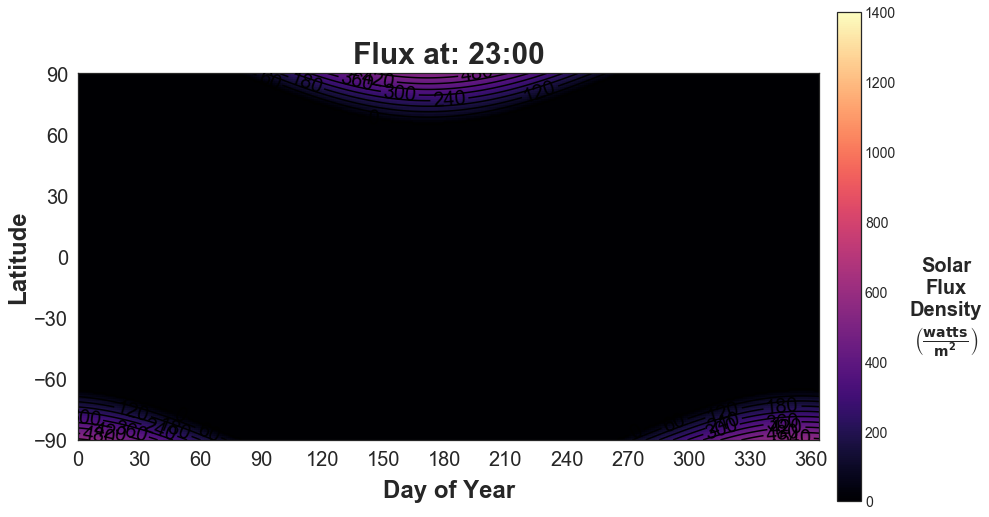

In [504]:
from IPython.display import clear_output

for hour in range(0, 24):
    fig = do_plot(days, hour, lats)
    clear_output(wait=True)
    plt.show()

### Animate over hours of day

In [ ]:
# Make Data
min_day = 0
max_day = 364
min_lat = -90
max_lat = 90
min_hour = 0
max_hour = 23

days_in_year = [day for day in range(max_day+1)]
latitudes = [lat for lat in range(min_lat, max_lat+1)]

days, lats = np.meshgrid(days_in_year, latitudes)

# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

In [3]:
#%%capture
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
# print(plt.style.available)
plt.style.use('seaborn-white')  # bmh is also nice


In [ ]:
frames = 24  # Number of frames in animation
num_contours = 9
alpha = 0.95  # 0 to 1
start_hour = 0
min_flux = 0
max_flux = 1400
colorbar_label = 'Solar Flux\nDensity ' + r'$\bf{\left(\frac{watts}{m^2}\right)}$'

fig, ax = plt.subplots(figsize=(16, 9))

def draw_plot(hour):
    #day = day*((max_day-1)//frames)
    flux = flux_function(days, hour, lats)
    contours = plt.contour(days, lats, flux, num_contours, colors='black')
    clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
    im = plt.imshow(flux, extent=[min_day, max_day, min_lat, max_lat],
                    origin='lower', cmap='magma', alpha = alpha, aspect='auto')
    plt.clim(min_flux, max_flux)
    title = plt.title("Hour of Day: " + '{0:02.0f}:{1:02.0f}'.format(*divmod(float(hour) * 60, 60)),
              fontsize=30, pad=10, weight='bold')
    return (im, contours, clabel, title)

fig, ax = plt.subplots(figsize=(16, 9))  # Put %%capture above so we dont display this as static plot

def init():
    flux = flux_function(days, start_hour, lats)
    im = draw_plot(start_hour)[0]
    cbar = plt.colorbar(im, pad=0.02)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel(colorbar_label, rotation = 0, wrap=True, fontsize=20, weight='bold', labelpad=50)

def bs():
    ax.clear()
    ax.set_xlabel('Day of Year', fontsize=24, weight='bold', labelpad=10)
    ax.set_ylabel('Latitude', fontsize=24, weight='bold')
    plt.tick_params(labelsize=20, pad=10)
    plt.xticks([d for d in range(min_day, max_day+1, 30)])
    plt.yticks([lat for lat in range(min_lat, max_lat+1, 30)])

def animate(hour):
    bs()
    return draw_plot(hour)


interval = 0.5  # in seconds
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=interval*1e+3,
                               blit=False)

HTML(anim.to_jshtml())  # FOR SOME FUCKING REASON WE NEED THIS HERE!
                        # Then either do JSAnimation.IPython_display.display_animation(anim) OR
                        # %%capture at top of this cell, and HTML(anim.to_jshtml()) again in another cell.

from JSAnimation.IPython_display import display_animation
display_animation(anim)

## Animate Either

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from JSAnimation.IPython_display import display_animation
# print(plt.style.available)
plt.style.use('seaborn-white')  # bmh is also nice

In [4]:
min_lat = -90
max_lat = 90
min_hour = 0
max_hour = 23
min_day = 0
max_day = 364
resolution = 4

days_in_year = [day for day in range(max_day+1)]
hours = [hour/resolution for hour in range(resolution*(max_hour+1)-1)]
latitudes = [lat for lat in range(min_lat, max_lat + 1)]

# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

frames = 48  # Number of frames in animation
num_contours = 20
alpha = 0.95  # 0 to 1
start_day = 0
min_flux = 0
max_flux = 1400
colorbar_label = 'Solar Flux\nDensity ' + r'$\bf{\left(\frac{watts}{m^2}\right)}$'

In [5]:
def make_animation(days, num_contours, frames):
    if days:
        x_var, lats = np.meshgrid(hours, latitudes)
        min_t, max_t, min_x, max_x = min_day, max_day, min_hour, max_hour
        title_start = "Day of Year: "
        x_lab = "Hour of Day"
        x_ticks = [d for d in range(max_hour+1)]
    else:
        x_var, lats = np.meshgrid(days_in_year, latitudes)
        min_t, max_t, min_x, max_x = min_hour, max_hour, min_day, max_day
        title_start = "Hour of Day: "
        x_lab = "Day of Year"
        x_ticks = [d for d in range(min_day, max_day+1, 30)]

    fig, ax = plt.subplots(figsize=(16, 9))

    def draw_plot(t):
        t = t*((max_t+1)/frames)
        flux = flux_function(t, x_var, lats) if days else flux_function(x_var, t, lats)
        contours = plt.contour(x_var, lats, flux, num_contours, colors='black')
        clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
        im = plt.imshow(flux, extent=[min_x, max_x, min_lat, max_lat],
                        origin='lower', cmap='magma', alpha = alpha, aspect='auto')
        plt.clim(min_flux, max_flux)
        title_end = str(int(t)) if days else '{0:02.0f}:{1:02.0f}'.format(*divmod(float(t) * 60, 60))
        title = plt.title(title_start+title_end, fontsize=30, pad=10, weight='bold')
        return (im, contours, clabel, title)

    def init():
        #flux = flux_function(start_day, hrs, lats)
        im = draw_plot(0)[0]
        cbar = plt.colorbar(im, pad=0.02)
        cbar.ax.tick_params(labelsize=20)
        cbar.ax.set_ylabel(colorbar_label, rotation = 0, fontsize=20, weight='bold', labelpad=70)

    def bs():
        ax.clear()
        ax.set_xlabel(x_lab, fontsize=24, weight='bold', labelpad=10)
        ax.set_ylabel('Latitude', fontsize=24, weight='bold')
        plt.tick_params(labelsize=20, pad=10)
        plt.xticks(x_ticks)
        plt.yticks([lat for lat in range(min_lat, max_lat+1, 30)])

    def animate(t):
        bs()
        return draw_plot(t)


    interval = 0.5  # in seconds
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=interval*1e+3,
                                   blit=False)
    return anim

    HTML(anim.to_jshtml())  # FOR SOME FUCKING REASON WE NEED THIS HERE!
                            # Then either do JSAnimation.IPython_display.display_animation(anim) OR
                            # %%capture at top of this cell, and HTML(anim.to_jshtml()) again in another cell.

    from JSAnimation.IPython_display import display_animation
    display_animation(anim)

In [8]:
anim = make_animation(days=False, num_contours=8, frames=12)

HTML(anim.to_jshtml())
display_animation(anim)

### Animate over days of year

In [ ]:
# Make Data
min_lat = -90
max_lat = 90
min_hour = 0
max_hour = 23
min_day = 0
max_day = 364
resolution = 4

hours = [hour/resolution for hour in range(resolution*(max_hour+1)-1)]
latitudes = [lat for lat in range(min_lat, max_lat + 1)]

hrs, lats = np.meshgrid(hours, latitudes)

# Vectorize Function
flux_function = np.vectorize(calculate_flux_density)

In [ ]:
frames = 24  # Number of frames in animation
num_contours = 20
alpha = 0.95  # 0 to 1
start_day = 0
min_flux = 0
max_flux = 1400
colorbar_label = 'Solar Flux\nDensity ' + r'$\bf{\left(\frac{watts}{m^2}\right)}$'

fig, ax = plt.subplots(figsize=(16, 9))

def draw_plot(day):
    day = day*((max_day-1)//frames)
    flux = flux_function(day, hrs, lats)
    contours = plt.contour(hrs, lats, flux, num_contours, colors='black')
    clabel = plt.clabel(contours, fontsize=20, fmt='%1.0f')
    im = plt.imshow(flux, extent=[min_hour, max_hour, min_lat, max_lat],
                    origin='lower', cmap='magma', alpha = alpha, aspect='auto')
    plt.clim(min_flux, max_flux)
    title = plt.title("Day of Year: " + str(day), fontsize=30, pad=10, weight='bold')
    return (im, contours, clabel, title)

def init():
    #flux = flux_function(start_day, hrs, lats)
    im = draw_plot(0)[0]
    cbar = plt.colorbar(im, pad=0.02)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel(colorbar_label, rotation = 0, fontsize=20, weight='bold', labelpad=70)

def bs():
    ax.clear()
    ax.set_xlabel('Hour of Day', fontsize=24, weight='bold', labelpad=10)
    ax.set_ylabel('Latitude', fontsize=24, weight='bold')
    plt.tick_params(labelsize=20, pad=10)
    plt.xticks([d for d in range(max_hour+1)])
    plt.yticks([lat for lat in range(min_lat, max_lat+1, 30)])

def animate(day):
    bs()
    return draw_plot(day)


interval = 0.5  # in seconds
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=interval*1e+3,
                               blit=False)

HTML(anim.to_jshtml())  # FOR SOME FUCKING REASON WE NEED THIS HERE!
                        # Then either do JSAnimation.IPython_display.display_animation(anim) OR
                        # %%capture at top of this cell, and HTML(anim.to_jshtml()) again in another cell.

from JSAnimation.IPython_display import display_animation
display_animation(anim)